# Model Training

In [1]:
import MIMENetEnsemble
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json

In [2]:
#set training parameters
training_path = "../data/experimental_data/training_data/training.txt"
model_path = "./experimental_model/experimental_model"
epochs = 30
learning_rate = 0.00001
batch_size = 2**14
lambda_l2 = 0.00001
hidden_size_factor = 2
bottleneck = 1/2
backup_interval = 1

In [3]:
model, history = MIMENetEnsemble.train(
    training_path=training_path,
    epochs=epochs,
    learning_rate=learning_rate,
    batch_size=batch_size,
    lambda_l2=lambda_l2,
    hidden_size_factor=hidden_size_factor,
    bottleneck=bottleneck,
    model_path=model_path,
    backup_interval=backup_interval
)

Device: cuda:0
Number of Training examples: 23616445
Loaded model from ./experimental_model/experimental_model.pt
Loaded optimizer from ./experimental_model/experimental_model_optimizer.pt


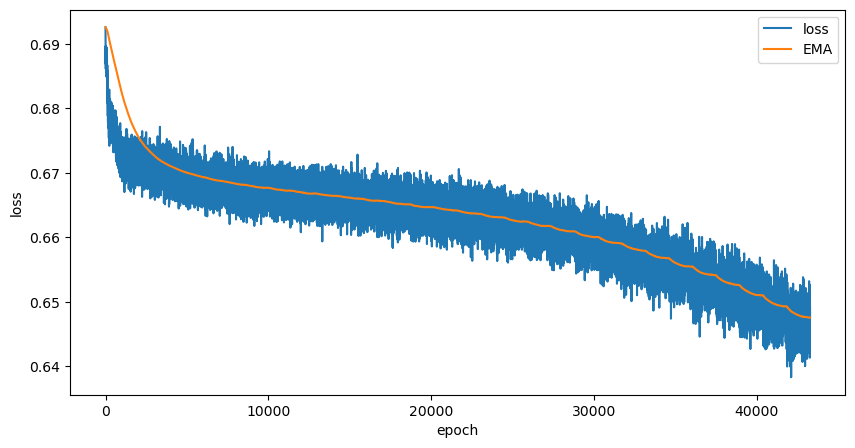

In [4]:
# load training history
train_history = np.loadtxt("./experimental_model/experimental_model_train_history.txt")

# plot training history
# set fig size
plt.figure(figsize=(10, 5))
plt.plot(range(len(train_history)), train_history)
# also plot exponential moving average
ema = []
ema.append(train_history[0])
for i in range(1, len(train_history)):
    ema.append(0.999*ema[i-1]+0.001*train_history[i])
plt.plot(range(len(ema)), ema)
plt.legend(["loss", "EMA"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [5]:
# load prediction history
prediction_history = np.loadtxt("./experimental_model/experimental_model_prediction_history.txt")
print(prediction_history.shape)
prediction_history[0]

(30, 2142)


array([0.48130957, 0.4765249 , 0.50037877, ..., 0.49780336, 0.50132061,
       0.49892326])

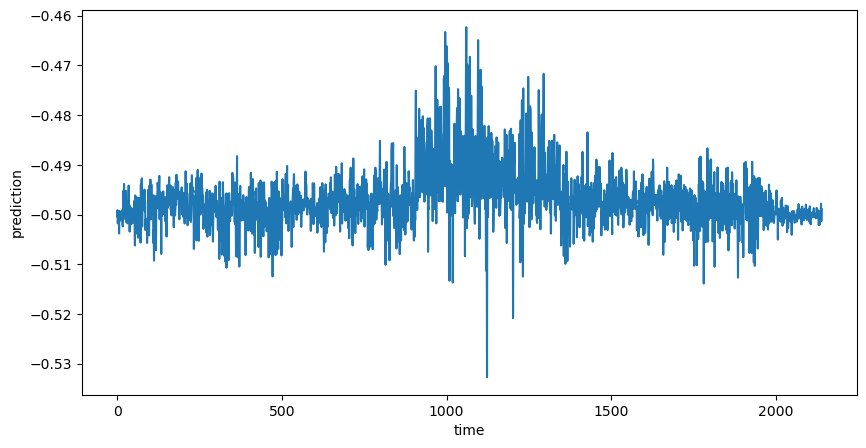

In [6]:
# line plot of last row of prediction history
plt.figure(figsize=(10, 5))
plt.plot(range(len(prediction_history[0][2:])), -1*prediction_history[0][2:])
plt.xlabel("time")
plt.ylabel("prediction")
plt.show()

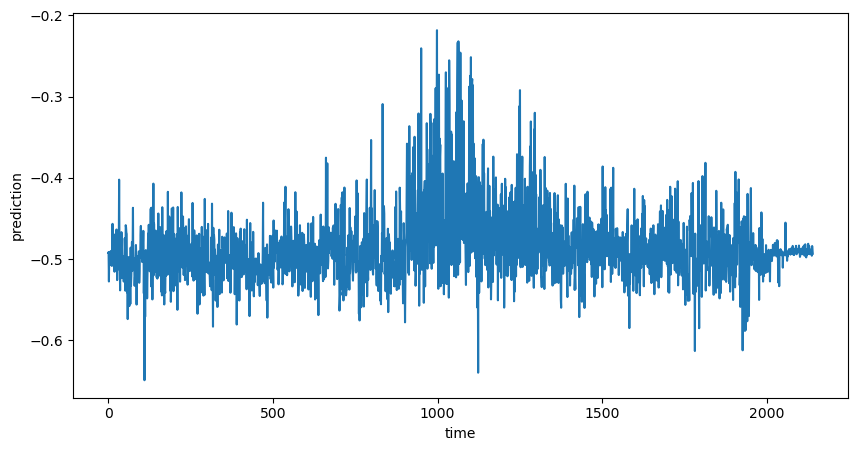

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(prediction_history[-1][2:])), -1*prediction_history[-1][2:])
plt.xlabel("time")
plt.ylabel("prediction")
plt.show()

In [3]:
#load history
with open('./experimental_model/experimental_model_history.json', 'r') as f:
    history = json.load(f)

In [3]:
#load final model
input_size = len(open(training_path).readline().split('_')[0])
model = MIMENetEnsemble.MIMENetEnsemble(input_size=input_size, hidden_size_factor=hidden_size_factor, bottleneck=bottleneck, output_size=1)
model.load_state_dict(torch.load('./experimental_model/experimental_model_final_model.pt'))
model.to('cuda')

MIMENetEnsemble(
  (fc1): Linear(in_features=2148, out_features=4296, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=4296, out_features=4296, bias=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=4296, out_features=4296, bias=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=4296, out_features=2148, bias=True)
  (dropout4): Dropout(p=0.2, inplace=False)
  (fc5): Linear(in_features=2148, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

Text(0, 0.5, 'Avg Difference')

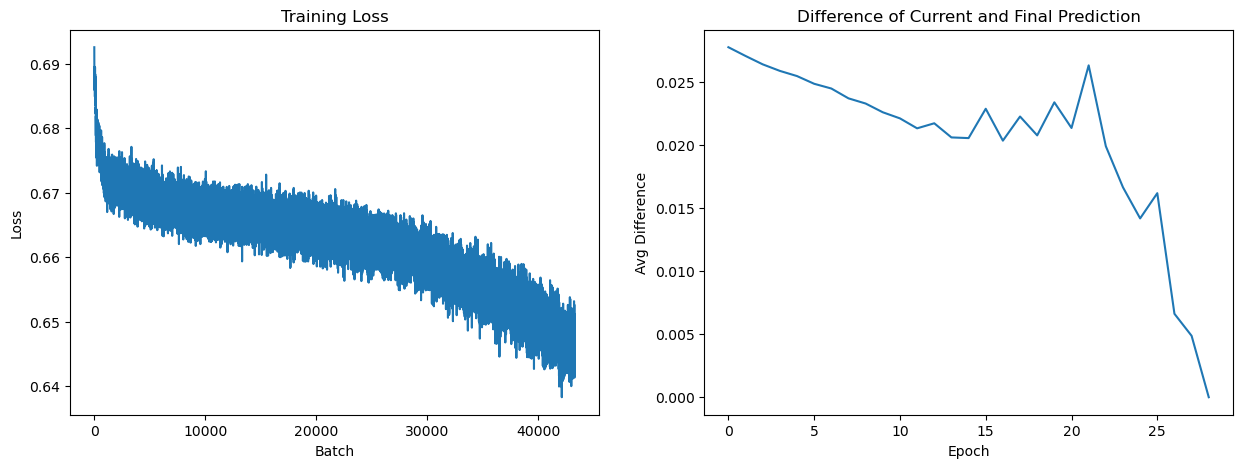

In [10]:
# set up 3 side by side plots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

#plot training history
axs[0].plot(history['training'])
axs[0].set_title('Training Loss')
axs[0].set_xlabel('Batch')
axs[0].set_ylabel('Loss')

#plot difference of current and final prediction

#initialize difference array
predictions = np.array(history['prediction'][1:])
difference = np.zeros((predictions.shape[0], predictions.shape[1]))
#calculate difference
for i in range(predictions.shape[0]):
    difference[i] = np.abs(predictions[i] - predictions[-1])
#average over columns
difference = np.mean(difference, axis=1)
#plot difference
axs[1].plot(difference)
axs[1].set_title('Difference of Current and Final Prediction')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Avg Difference')

In [5]:
path_wildtype = "../data/experimental_data/5NL43.txt"

In [12]:
with open(path_wildtype, 'r') as f:
        wildtype = f.read()
        
print(wildtype)

GGTCTCTCTGGTTAGACCAGATCTGAGCCTGGGAGCTCTCTGGCTAACTAGGGAACCCACTGCTTAAGCCTCAATAAAGCTTGCCTTGAGTGCTCAAAGTAGTGTGTGCCCGTCTGTTGTGTGACTCTGGTAACTAGAGATCCCTCAGACCCTTTTAGTCAGTGTGGAAAATCTCTAGCAGTGGCGCCCGAACAGGGACTTGAAAGCGAAAGTAAAGCCAGAGGAGATCTCTCGACGCAGGACTCGGCTTGCTGAAGCGCGCACGGCAAGAGGCGAGGGGCGGCGACTGGTGAGTACGCCAAAAATTTTGACTAGCGGAGGCTAGAAGGAGAGAGATGGGTGCGAGAGCGTCGGTATTAAGCGGGGGAGAATTAGATAAATGGGAAAAAATTCGGTTAAGGCCAGGGGGAAAGAAACAATATAAACTAAAACATATAGTATGGGCAAGCAGGGAGCTAGAACGATTCGCAGTTAATCCTGGCCTTTTAGAGACATCAGAAGGCTGTAGACAAATACTGGGACAGCTACAACCATC


In [6]:
kds_nucleotide, kds_position = MIMENetEnsemble.inferSingleKds(model, 4, 2, path_wildtype, 5)

100%|██████████| 535/535 [00:09<00:00, 55.44it/s]


In [7]:
kds_nucleotide = np.array(kds_nucleotide)
kds_position = np.array(kds_position)

print(kds_nucleotide.shape)
print(kds_position.shape)

(1605, 5)
(535, 5)


In [8]:
# save single kd predictions
np.savetxt('./experimental_model/kds_nucleotide.txt', kds_nucleotide)
np.savetxt('./experimental_model/kds_position.txt', kds_position)

In [3]:
# load single kd predictions
kds_nucleotide = np.loadtxt('./experimental_model/kds_nucleotide.txt')
kds_position = np.loadtxt('./experimental_model/kds_position.txt')

In [8]:
kds_nucleotide_means = np.mean(kds_nucleotide, axis=1)
kds_nucleotide_confidence = np.zeros((kds_nucleotide.shape[0], 2))
for i in range(kds_nucleotide.shape[0]):
    kds_nucleotide_confidence[i] = np.quantile(kds_nucleotide[i], [0.025, 0.975])

kds_position_means = np.mean(kds_position, axis=1)
kds_position_confidence = np.zeros((kds_position.shape[0], 2))
for i in range(kds_position.shape[0]):
    kds_position_confidence[i] = np.quantile(kds_position[i], [0.005, 0.975])

print(kds_nucleotide_means.shape)
print(kds_nucleotide_confidence.shape)
print(kds_position_means.shape)
print(kds_position_confidence.shape)

(1605,)
(1605, 2)
(535,)
(535, 2)


In [18]:
# iterate over all nucleotide kds and check if they are significant
significant_kds = []
for i in range(kds_nucleotide.shape[0]):
    if kds_nucleotide_confidence[i, 0] > 1 or kds_nucleotide_confidence[i, 1] < 1:
        significant_kds.append(1)
    else:
        significant_kds.append(0)

print(sum(significant_kds))

352


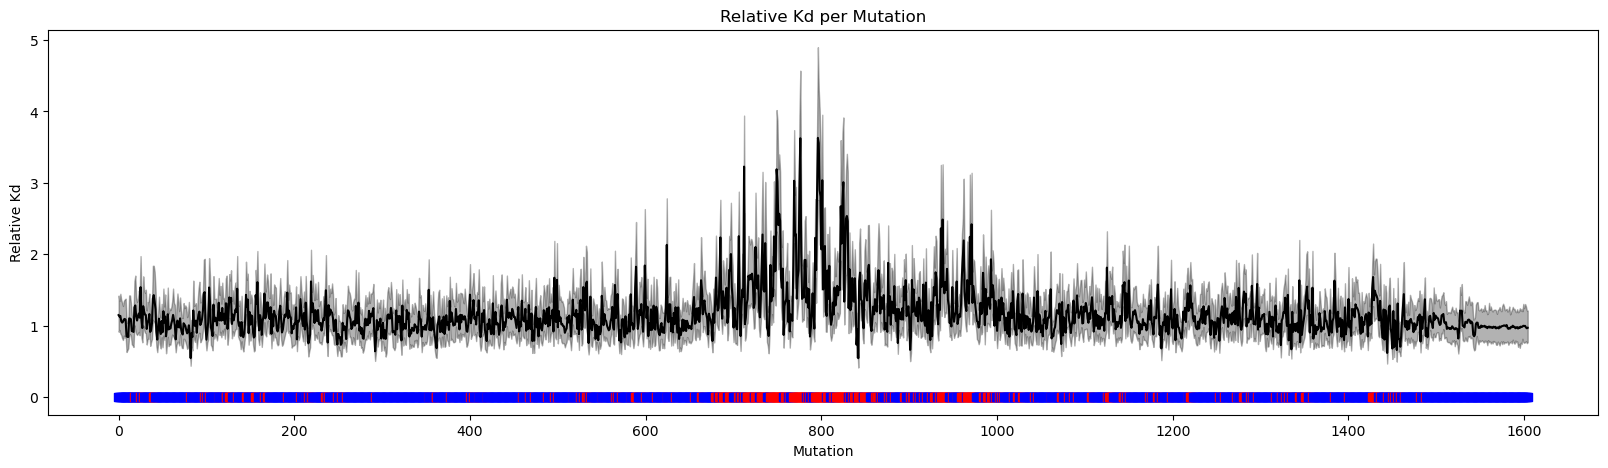

In [19]:
# plot kd per nucleotide along sequence with confidence interval as lower alpha
plt.figure(figsize=(20, 5))
plt.plot(kds_nucleotide_means, color='black')
plt.fill_between(np.arange(kds_nucleotide_means.shape[0]), kds_nucleotide_confidence[:, 0], kds_nucleotide_confidence[:, 1], alpha=0.3, color='black')
plt.scatter(np.arange(kds_nucleotide_means.shape[0]), np.zeros(kds_nucleotide_means.shape[0]), c=significant_kds, cmap='bwr', marker=',')
plt.xlabel('Mutation')
plt.ylabel('Relative Kd')
plt.title('Relative Kd per Mutation')
plt.show()

In [20]:
# iterate over all position kds and check if they are significant
significant_kds = []
for i in range(kds_position.shape[0]):
    if kds_position_confidence[i, 0] > 1 or kds_position_confidence[i, 1] < 1:
        significant_kds.append(1)
    else:
        significant_kds.append(0)

print(sum(significant_kds))

103


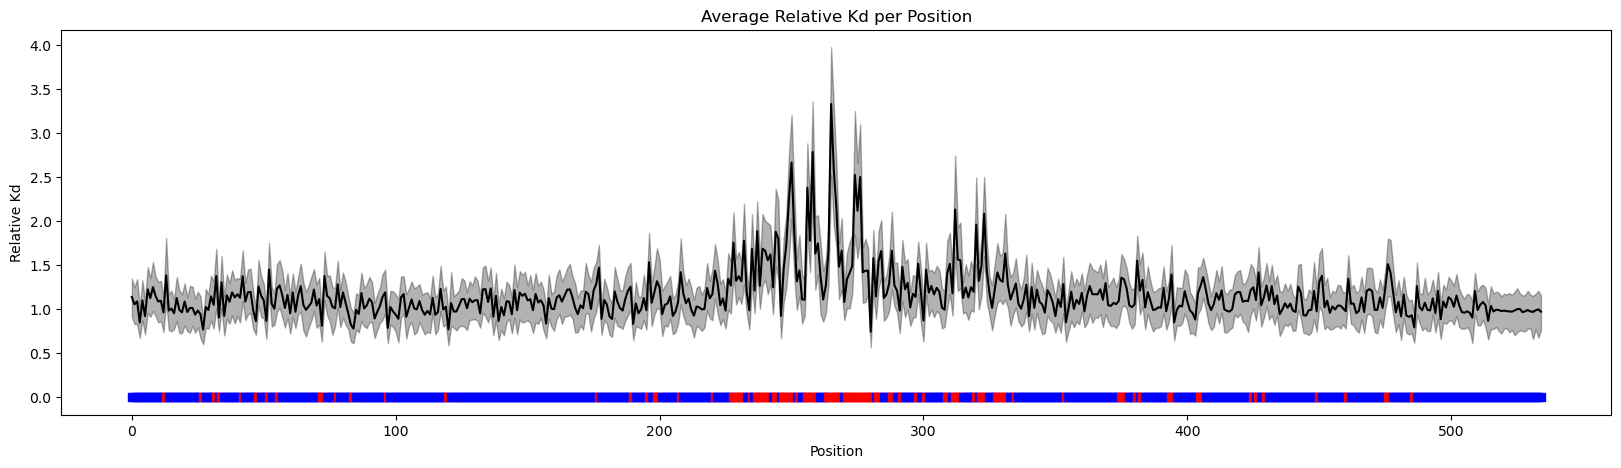

In [21]:
# plot kd per position along sequence with confidence interval as lower alpha
plt.figure(figsize=(20, 5))
plt.plot(kds_position_means, color='black')
plt.fill_between(np.arange(kds_position_means.shape[0]), kds_position_confidence[:, 0], kds_position_confidence[:, 1], alpha=0.3, color='black')
plt.scatter(np.arange(kds_position_means.shape[0]), np.zeros(kds_position_means.shape[0]), c=significant_kds, cmap='bwr', marker=',')
plt.xlabel('Position')
plt.ylabel('Relative Kd')
plt.title('Average Relative Kd per Position')
plt.show()

In [26]:
kds_pairwise = MIMENetEnsemble.inferPairwiseKds(model, 4, 2, path_wildtype, 10)

KeyboardInterrupt: 

In [23]:
n = 100

print((n*(n-1)/2)*9)

n = 535

print((n*(n-1)/2)*9)

44550.0
1285605.0


In [24]:
kds_pairwise = np.array(kds_pairwise)
print(kds_pairwise.shape)

(1285605, 5)


In [25]:
# save pairwise kds
np.savetxt('./experimental_model/pairwise_kds.txt', kds_pairwise)

In [25]:
# load single kd predictions
kds_nucleotide = np.loadtxt('./experimental_model/kds_nucleotide.txt')
kds_position = np.loadtxt('./experimental_model/kds_position.txt')
print(len(kds_nucleotide))
print(len(kds_nucleotide[0]))

# load pairwise kds
kds_nucleotide = kds_nucleotide.tolist()
kds_pairwise = np.loadtxt('./experimental_model/pairwise_kds.txt').tolist()
print(len(kds_pairwise))
print(len(kds_pairwise[0]))

1605
5
1285605
5


In [26]:
def inferEpistasis(singleKds : list, pairwiseKds : list):
    
    single_kd_pred = np.array(singleKds)

    pairwise_kd_pred = np.array(pairwiseKds)

    #iterate through all possible pairs
    epistasis = []
    pairs = []
    i = 0
    for pos1 in range(single_kd_pred.shape[0], 3):
        for pos2 in range(pos1+1, single_kd_pred.shape[0], 3):
            for mut1 in range(3):
                for mut2 in range(3):
                    
                    # get single kds
                    single_kd_1 = single_kd_pred[pos1+mut1]
                    single_kd_2 = single_kd_pred[pos2+mut2]
                    # get pairwise kd
                    pairwise_kd = pairwise_kd_pred[i]

                    # check how often the pairwise kd is lower than the product of the single kds
                    check = pairwise_kd < single_kd_1 * single_kd_2
                    count = np.sum(check)


                    # # predict epistasis if more than 95% of the predictions are lower
                    # if count / pairwise_kd.shape[0] > 0.95:
                    #     epistasis.append(1)
                    # else:
                    #     epistasis.append(0)

                    epistasis.append(count / pairwise_kd.shape[0])

                    pairs.append((pos1+mut1, pos2+mut2))

                    i += 1

    return epistasis, pairs

In [27]:
epistasis, pairs = inferEpistasis(kds_nucleotide, kds_pairwise)

In [28]:
epistasis

[]

In [29]:
epistasis_epistasis_nucleotides, nucleotide_pairs, epistasis_positions, position_pairs = MIMENetEnsemble.computeEpistasis(kds_nucleotide, kds_pairwise)

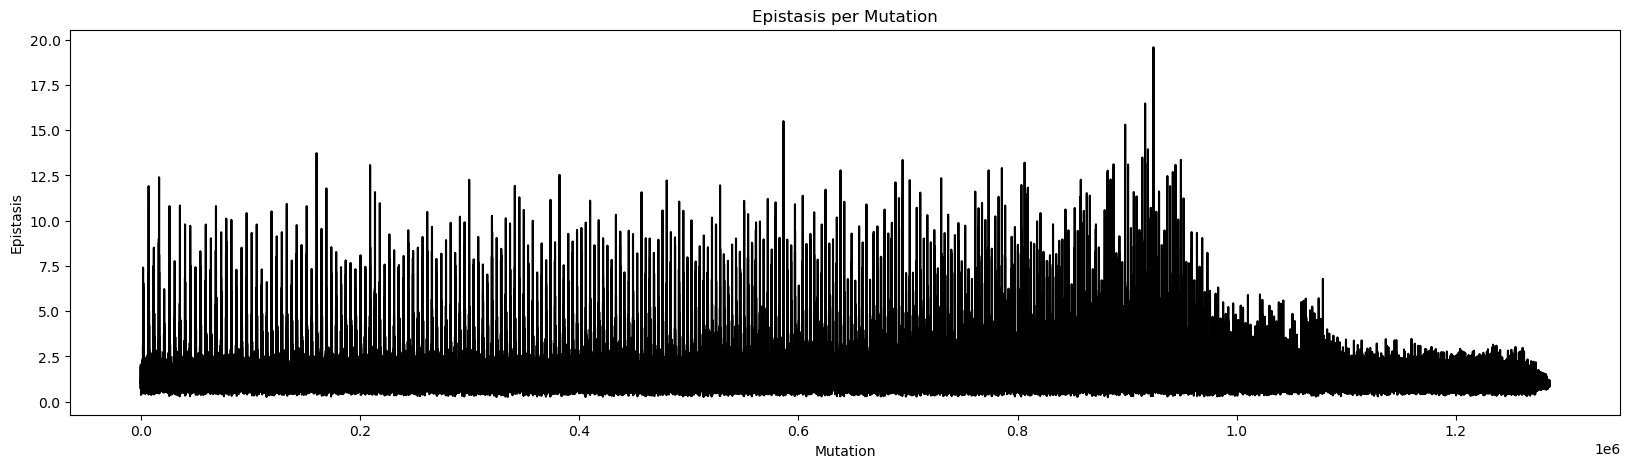

In [30]:
# lineplot of epistasis
plt.figure(figsize=(20, 5))
plt.plot(epistasis_epistasis_nucleotides, color='black')
plt.xlabel('Mutation')
plt.ylabel('Epistasis')
plt.title('Epistasis per Mutation')
plt.show()

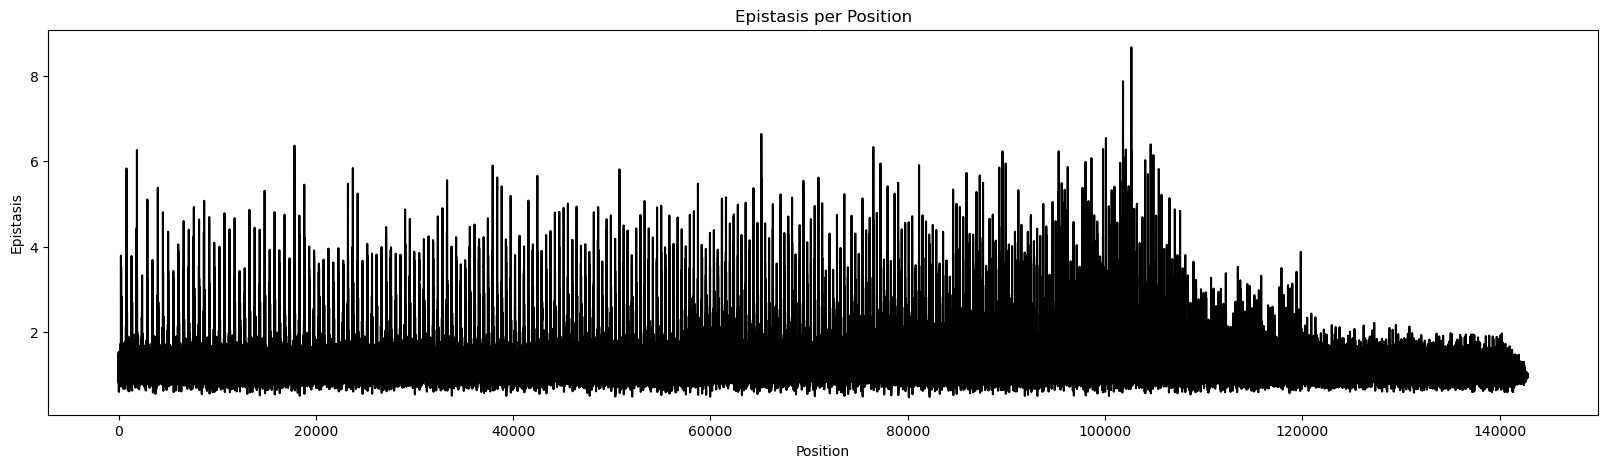

In [31]:
# plot epistasis positions
plt.figure(figsize=(20, 5))
plt.plot(epistasis_positions, color='black')
plt.xlabel('Position')
plt.ylabel('Epistasis')
plt.title('Epistasis per Position')
plt.show()

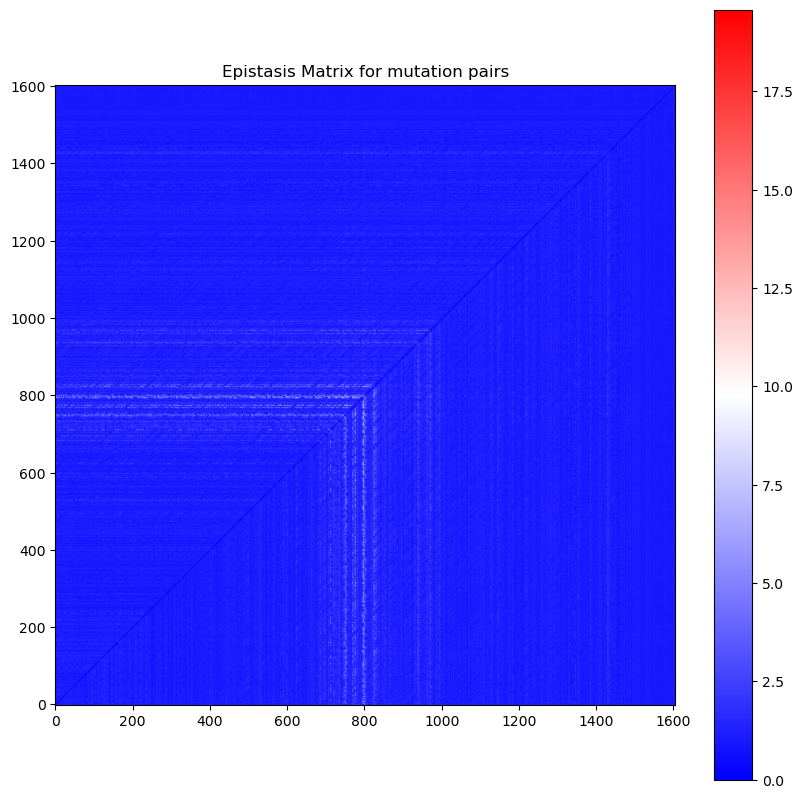

In [49]:
# create 1605x1605 matrix with epistasis values
epistasis_matrix = np.zeros((1605, 1605))
for i in range(len(nucleotide_pairs)):
    epistasis_matrix[nucleotide_pairs[i][0], nucleotide_pairs[i][1]] = epistasis_epistasis_nucleotides[i]
    epistasis_matrix[nucleotide_pairs[i][1], nucleotide_pairs[i][0]] = epistasis_epistasis_nucleotides[i] 

# plot epistasis matrix as heatmap
plt.figure(figsize=(10, 10))
plt.imshow(epistasis_matrix, cmap='bwr')
# flip y axis to match sequence
plt.gca().invert_yaxis()
plt.colorbar()
plt.title('Epistasis Matrix for mutation pairs')
plt.show()

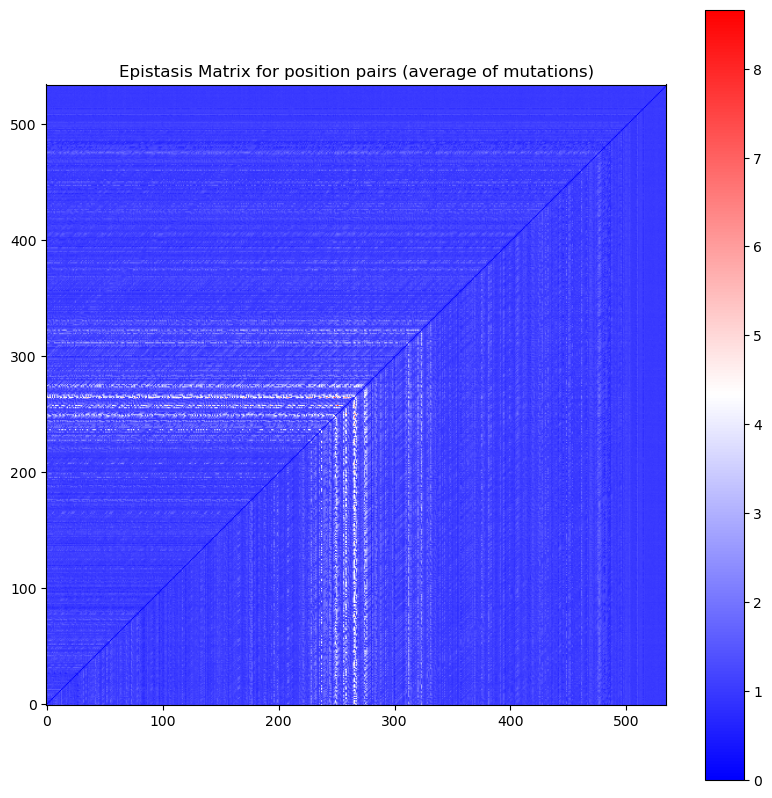

In [52]:
# create 535x535 matrix with epistasis values
epistasis_matrix = np.zeros((535, 535))
for i in range(len(position_pairs)):
    epistasis_matrix[position_pairs[i][0], position_pairs[i][1]] = epistasis_positions[i]
    epistasis_matrix[position_pairs[i][1], position_pairs[i][0]] = epistasis_positions[i]

# plot epistasis matrix as heatmap
plt.figure(figsize=(10, 10))
plt.imshow(epistasis_matrix, cmap='bwr')
# invert y axis to match sequence
plt.gca().invert_yaxis()
plt.colorbar()
plt.title('Epistasis Matrix for position pairs (average of mutations)')
plt.show()

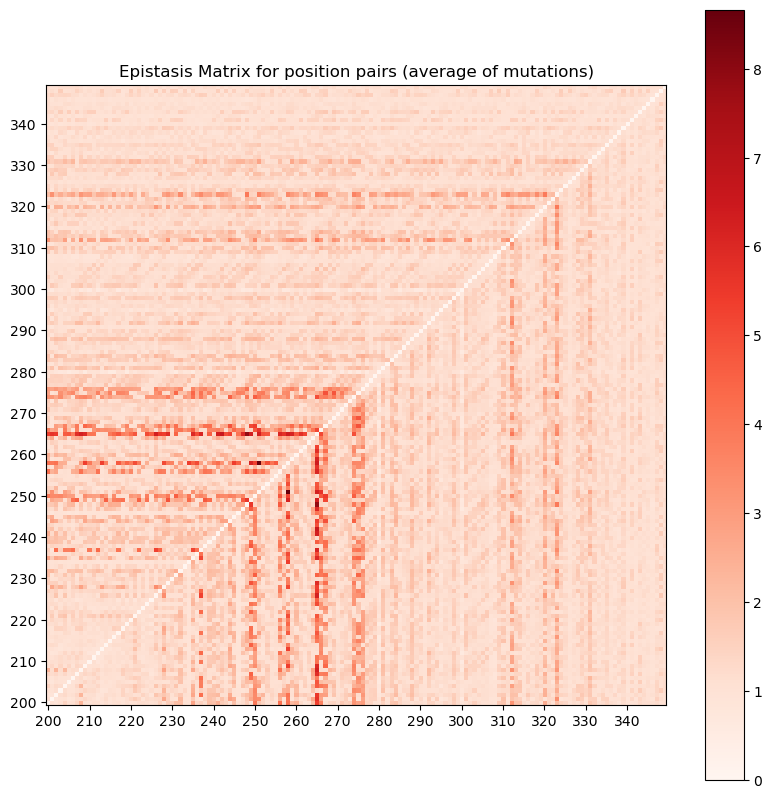

In [54]:
# only use rows/cols 200-350
epistasis_matrix_zoom = epistasis_matrix[200:350, 200:350]

# plot epistasis matrix as heatmap
plt.figure(figsize=(10, 10))
plt.imshow(epistasis_matrix_zoom, cmap='Reds')
# invert y axis to match sequence
plt.gca().invert_yaxis()
# add 200 to x and y ticks
plt.xticks(np.arange(0, 150, 10), np.arange(200, 350, 10))
plt.yticks(np.arange(0, 150, 10), np.arange(200, 350, 10))
plt.colorbar()
plt.title('Epistasis Matrix for position pairs (average of mutations)')
plt.show()